# Importing Libraries

In [262]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cdist

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (30,30)

import warnings
warnings.filterwarnings("ignore")

# Data Cleaning

This section aims to prepare the player statistics data required for clustering. This was not included in the main data cleaning folder as optimization for the ideal clustering model may require various testing, which includes addition or deletion of features, hence the original csv was untouched prior to this notebook to ensure no data leakage and convenience for any alteration during testing phase.

In [263]:
df = pd.read_csv('player_stats_1990-2019.csv')

In [264]:
# Check for missing values
df.isna().sum()

slug                                   0
player_id                              0
height_cm                              0
weight_kg                              0
first_serve_perc                       0
first_serve_points_won_perc            0
second_serve_points_won_perc           0
first_serve_return_points_won_perc     0
second_serve_return_points_won_perc    0
break_points_saved_perc                0
break_points_converted_perc            0
service_games_won_perc                 0
service_points_won_perc                0
return_games_won_perc                  0
return_points_won_perc                 0
dtype: int64

In [265]:
# Convert all percentages into 0.xx
for i in df.columns[4:]:
    df[i] = df[i].map(lambda x: x/100)

## Scaling Functions

In [266]:
# Use MinMaxScaler to normalize data
def df_to_array_scaled(df):
    X = np.array(df)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled

def df_scaled(df):
    normalized_df = (df-df.mean())/df.std()
    return normalized_df

# Feature Engineering & Selection

To optimize for clustering performance, we will conduct various experiments in this section by carefully selecting features to be added or removed for testing. 

For K-Means Clustering, we will only be tuning for n_clusters in this section. Subsequently, we will optimize for other hyperparameters like init, max_iter and algorithm on the finalized features.

Silhouette and Calinski-Harabasz Score will be used for model evaluation.
* Silhouette Score measures the eucledian distance between elements within own cluster compared to other clusters
* Calinski-Harabasz Score measures the ratio between "within-clusters" and "between-clusters"

__Test Schedule__

* __Test 1: All Initial Features__
* __Test 2: Service-Return Ratios__
* __Test 3: Break Point Percentages__
* __Test 4: First Serves Performance__
* __Test 5: Second Serve & Return Performance__
* __Test 6: Pressure Point Metrics__
* __Test 7: Interaction of Serve & Return Metrics__
* __Test 8: Addition to Test 2__

## K-Means Clustering

### Functions

In [267]:
def elbow_plot(df, k_min = 1, k_max = 20):

    # k means determine k
    distortions = []
    K = range(k_min,k_max)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.figure(figsize=(20,10))
    plt.show()

### Test 1: All Initial Features

In [42]:
df_test1 = df.drop(['slug', 'player_id'], axis = 1)

In [47]:
k_means1 = KMeans(n_clusters=2)
k_means1.fit(df_test1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [48]:
labels1 = k_means1.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test1, labels1, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test1, labels1)}")  

Silhouette Score: 0.9324845619093322
Calinski-Harabasz Score: 527.5394846623212


### Test 2: Service-Return Ratios

In [201]:
df.drop(['slug', 'player_id'], axis = 1, inplace = True)

In [202]:
# Create new columns for ratios
df['service_return_games_ratio'] = np.nan
df['service_return_points_ratio'] = np.nan

# Apply formula to populate both columns
for i in range(0, len(df)):
    df['service_return_games_ratio'][i] = \
    df['service_games_won_perc'][i] / df['return_games_won_perc'][i]
    
    df['service_return_points_ratio'][i] = \
    df['service_points_won_perc'][i] / df['return_points_won_perc'][i]

In [203]:
# Drop other columns
df_test2 = df.drop(df.columns[:-2], axis = 1)

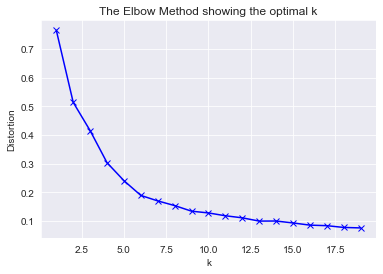

<Figure size 1440x720 with 0 Axes>

In [52]:
elbow_plot(df_test2)

In [53]:
k_means2 = KMeans(n_clusters=2, random_state = 42)
k_means2.fit(df_test2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [54]:
labels2 = k_means2.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test2, labels2, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test2, labels2)}")  

Silhouette Score: 0.6147581532552269
Calinski-Harabasz Score: 619.7806664698721


In [57]:
# Assigning labels
df_test2['group'] = k_means2.predict(df_test2)

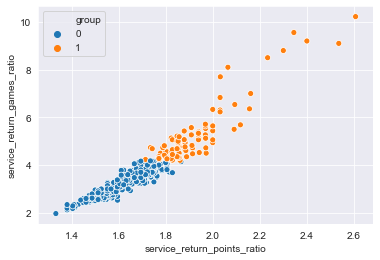

In [58]:
sns.scatterplot(y = df_test2[df_test2.columns[0]], x= df_test2[df_test2.columns[1]], hue = 'group', data = df_test2)

#### Experimenting with MinMaxScaler

In [98]:
df_test2_1 = df_to_array_scaled(df_test2)

k_means2_1 = KMeans(n_clusters=2)
k_means2_1.fit(df_test2_1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [60]:
labels2_1 = k_means2_1.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test2_1, labels2_1, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test2_1, labels2_1)}")  

Silhouette Score: 0.8807690730087872
Calinski-Harabasz Score: 6384.831545957696


In [64]:
# Assigning labels
df_test2_1['group'] = k_means2_1.predict(df_test2_1)

#### PCA

In [219]:
pca = PCA(n_components = 2)
transformed = pca.fit_transform(df_test2_1)

In [220]:
pca.explained_variance_ratio_

array([0.94583743, 0.03254037])

In [221]:
pca_df = pd.DataFrame(transformed, columns = ['PC1', 'PC2'])
pca_df.head()

df_test9 = pca_df

In [222]:
k_means9 = KMeans(n_clusters=2)
k_means9.fit(df_test9)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [223]:
labels9 = k_means9.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test9, labels9, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test9, labels9)}")  

Silhouette Score: 0.6383563544849882
Calinski-Harabasz Score: 719.5530762976385


### Test 3: Break Point Percentages

This model will be useful for differentiating players' performances under break point pressure

In [17]:
to_drop = []
for i in df.columns:
    if i.startswith('break_') == False:
        to_drop.append(i)

df_test3 = df.drop(to_drop, axis = 1)

In [18]:
k_means3 = KMeans(n_clusters=2)
k_means3.fit(df_test3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [19]:
labels3 = k_means3.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test3, labels3, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test3, labels3)}") 

Silhouette Score: 0.3610367400865022
Calinski-Harabasz Score: 298.62980302474796


### Test 4: First Serves Performance

In [20]:
df_test4 = df.drop(df.columns[:2], axis = 1)
df_test4.drop(df_test4.columns[2:], axis = 1, inplace = True)

In [21]:
k_means4 = KMeans(n_clusters=2)
k_means4.fit(df_test4)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [22]:
labels4 = k_means4.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test4, labels4, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test4, labels4)}") 

Silhouette Score: 0.37831820805789584
Calinski-Harabasz Score: 371.347970346151


### Test 5: Second Serve & Return Performance

This model will be useful to differentiate players' performance under pressure as they or their opponent missed the first serve, hence giving the receving player an increased chance of winning the point.

In [168]:
to_drop = []
for i in df.columns:
    if i.startswith('second_') == False:
        to_drop.append(i)

df_test5 = df.drop(to_drop, axis = 1)

In [169]:
k_means5 = KMeans(n_clusters=2)
k_means5.fit(df_test5)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [170]:
labels5 = k_means5.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test5, labels5, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test5, labels5)}")

Silhouette Score: 0.3436695015585933
Calinski-Harabasz Score: 283.66349255499136


### Test 6: Pressure Point Metrics (Combining Test 3 & 5)

In [26]:
to_drop = []
for i in df.columns:
    if i.startswith('second_') == True:
        pass
    elif i.startswith('break_') == True:
        pass
    else:
        to_drop.append(i)

df_test6 = df.drop(to_drop, axis = 1)

In [27]:
k_means6 = KMeans(n_clusters=2)
k_means6.fit(df_test6)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [28]:
labels6 = k_means6.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test6, labels6, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test6, labels6)}")

Silhouette Score: 0.2957354053761005
Calinski-Harabasz Score: 227.89203941904358


### Test 7: Interaction of Serve and Return Metrics

#### Test 7.1: Average of First & Second Serve & Return Metrics

<code>serve_average</code> = <code>(first_serve_points_won_perc + second_serve_points_won_perc)</code> / 2

<code>return_average</code> = <code>(first_serve_return_points_won_perc + second_serve_return_points_won_perc)</code> / 2

In [290]:
df['serve_average'] = np.nan
df['return_average'] = np.nan

for i in range(0, len(df)):
    df['serve_average'][i] = \
    (df['first_serve_points_won_perc'][i] + df['second_serve_points_won_perc'][i]) / 2
    
    df['return_average'][i] = \
    (df['first_serve_return_points_won_perc'][i] / df['second_serve_return_points_won_perc'][i]) / 2

In [291]:
df_test7_1 = df.drop(df.columns[:-2], axis = 1)

In [292]:
k_means7_1 = KMeans(n_clusters=2)
k_means7_1.fit(df_test7_1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [293]:
labels7_1 = k_means7_1.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test7_1, labels7_1, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test7_1, labels7_1)}")  

Silhouette Score: 0.39748846184391884
Calinski-Harabasz Score: 416.66919543203323


#### Test 7.2: Product of First & Second Serve & Return Metrics

In [294]:
df['serve_product'] = np.nan
df['return_product'] = np.nan

for i in range(0, len(df)):
    df['serve_product'][i] = \
    df['first_serve_points_won_perc'][i] * df['second_serve_points_won_perc'][i]
    
    df['return_product'][i] = \
    df['first_serve_return_points_won_perc'][i] * df['second_serve_return_points_won_perc'][i]

In [295]:
df_test7_2 = df.drop(df.columns[:-2], axis = 1)

In [296]:
k_means7_2 = KMeans(n_clusters=2)
k_means7_2.fit(df_test7_2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [297]:
labels7_2 = k_means7_2.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test7_2, labels7_2, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test7_2, labels7_2)}")

Silhouette Score: 0.40603808498649485
Calinski-Harabasz Score: 419.16083398919454


### Test 8: Add Serve:Return Product Metrics Ratio to Test 2

Adding another Serve-to-Return Ratio to our best performing model (Test 2: Service-Return Ratio) so far. 

*Note: Test 2 did not use any features used to populate the product interaction metrics*

In [298]:
df_test8 = df.drop(df.columns[:13], axis = 1)

to_drop = ['serve_average', 'return_average']
df_test8.drop(to_drop, axis = 1, inplace = True)

In [299]:
k_means8 = KMeans(n_clusters=2)
k_means8.fit(df_test8)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [300]:
labels8 = k_means8.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test8, labels8, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test8, labels8)}")

Silhouette Score: 0.40603808498649485
Calinski-Harabasz Score: 419.16083398919454


### Test 9: Add Height to Test 2

In [161]:
df_test12 = df

In [163]:
to_drop = ['weight_kg', 'first_serve_perc',
       'first_serve_points_won_perc', 'second_serve_points_won_perc',
       'first_serve_return_points_won_perc',
       'second_serve_return_points_won_perc', 'break_points_saved_perc',
       'break_points_converted_perc', 'service_games_won_perc',
       'service_points_won_perc', 'return_games_won_perc',
       'return_points_won_perc']

df_test12.drop(to_drop, axis = 1, inplace = True)

In [187]:
k_means12 = KMeans(n_clusters=2)
k_means12.fit(df_test12)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [188]:
labels12 = k_means12.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test12, labels12, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test12, labels12)}")

Silhouette Score: 0.9024364122324342
Calinski-Harabasz Score: 245.89167666989073


## Hierarchical Agglomerative Clustering

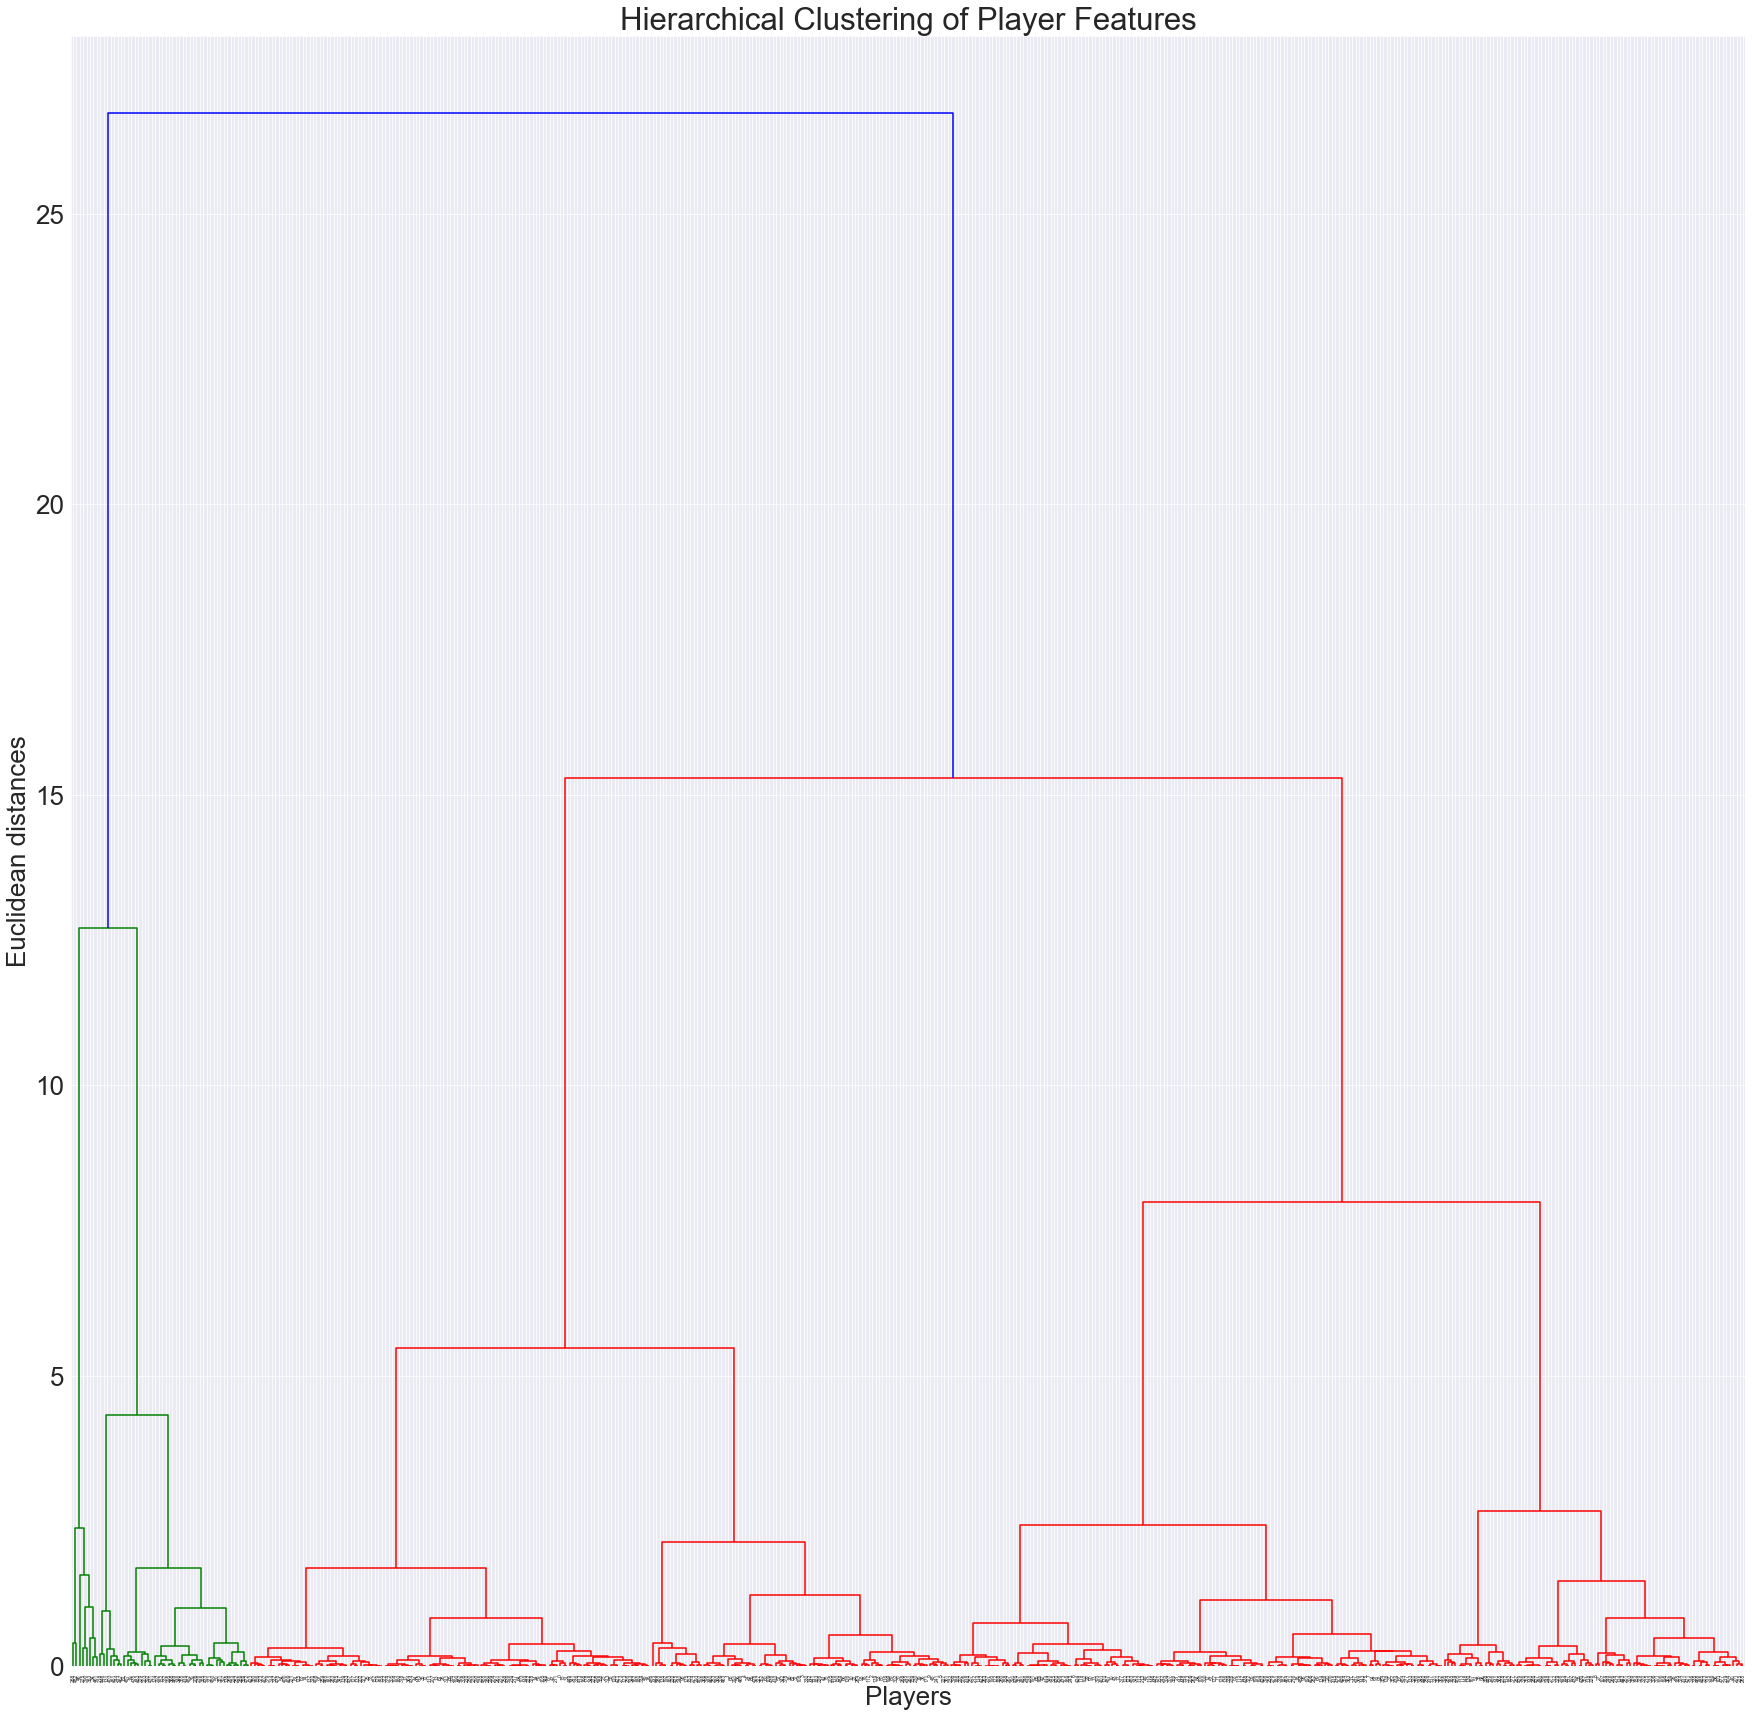

In [150]:
dendrogram = sch.dendrogram(sch.linkage(df_test2, method  = "ward"))
plt.title('Hierarchical Clustering of Player Features')
plt.xlabel('Players')
plt.ylabel('Euclidean distances')
plt.show()

In [151]:
hc_test1 = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
hc_test1.fit(df_test2)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2,
                        pooling_func='deprecated')

In [152]:
hc_labels1 = hc_test1.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test2, hc_labels1, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test2, hc_labels1)}")  

Silhouette Score: 0.701659931197813
Calinski-Harabasz Score: 626.6825418986584


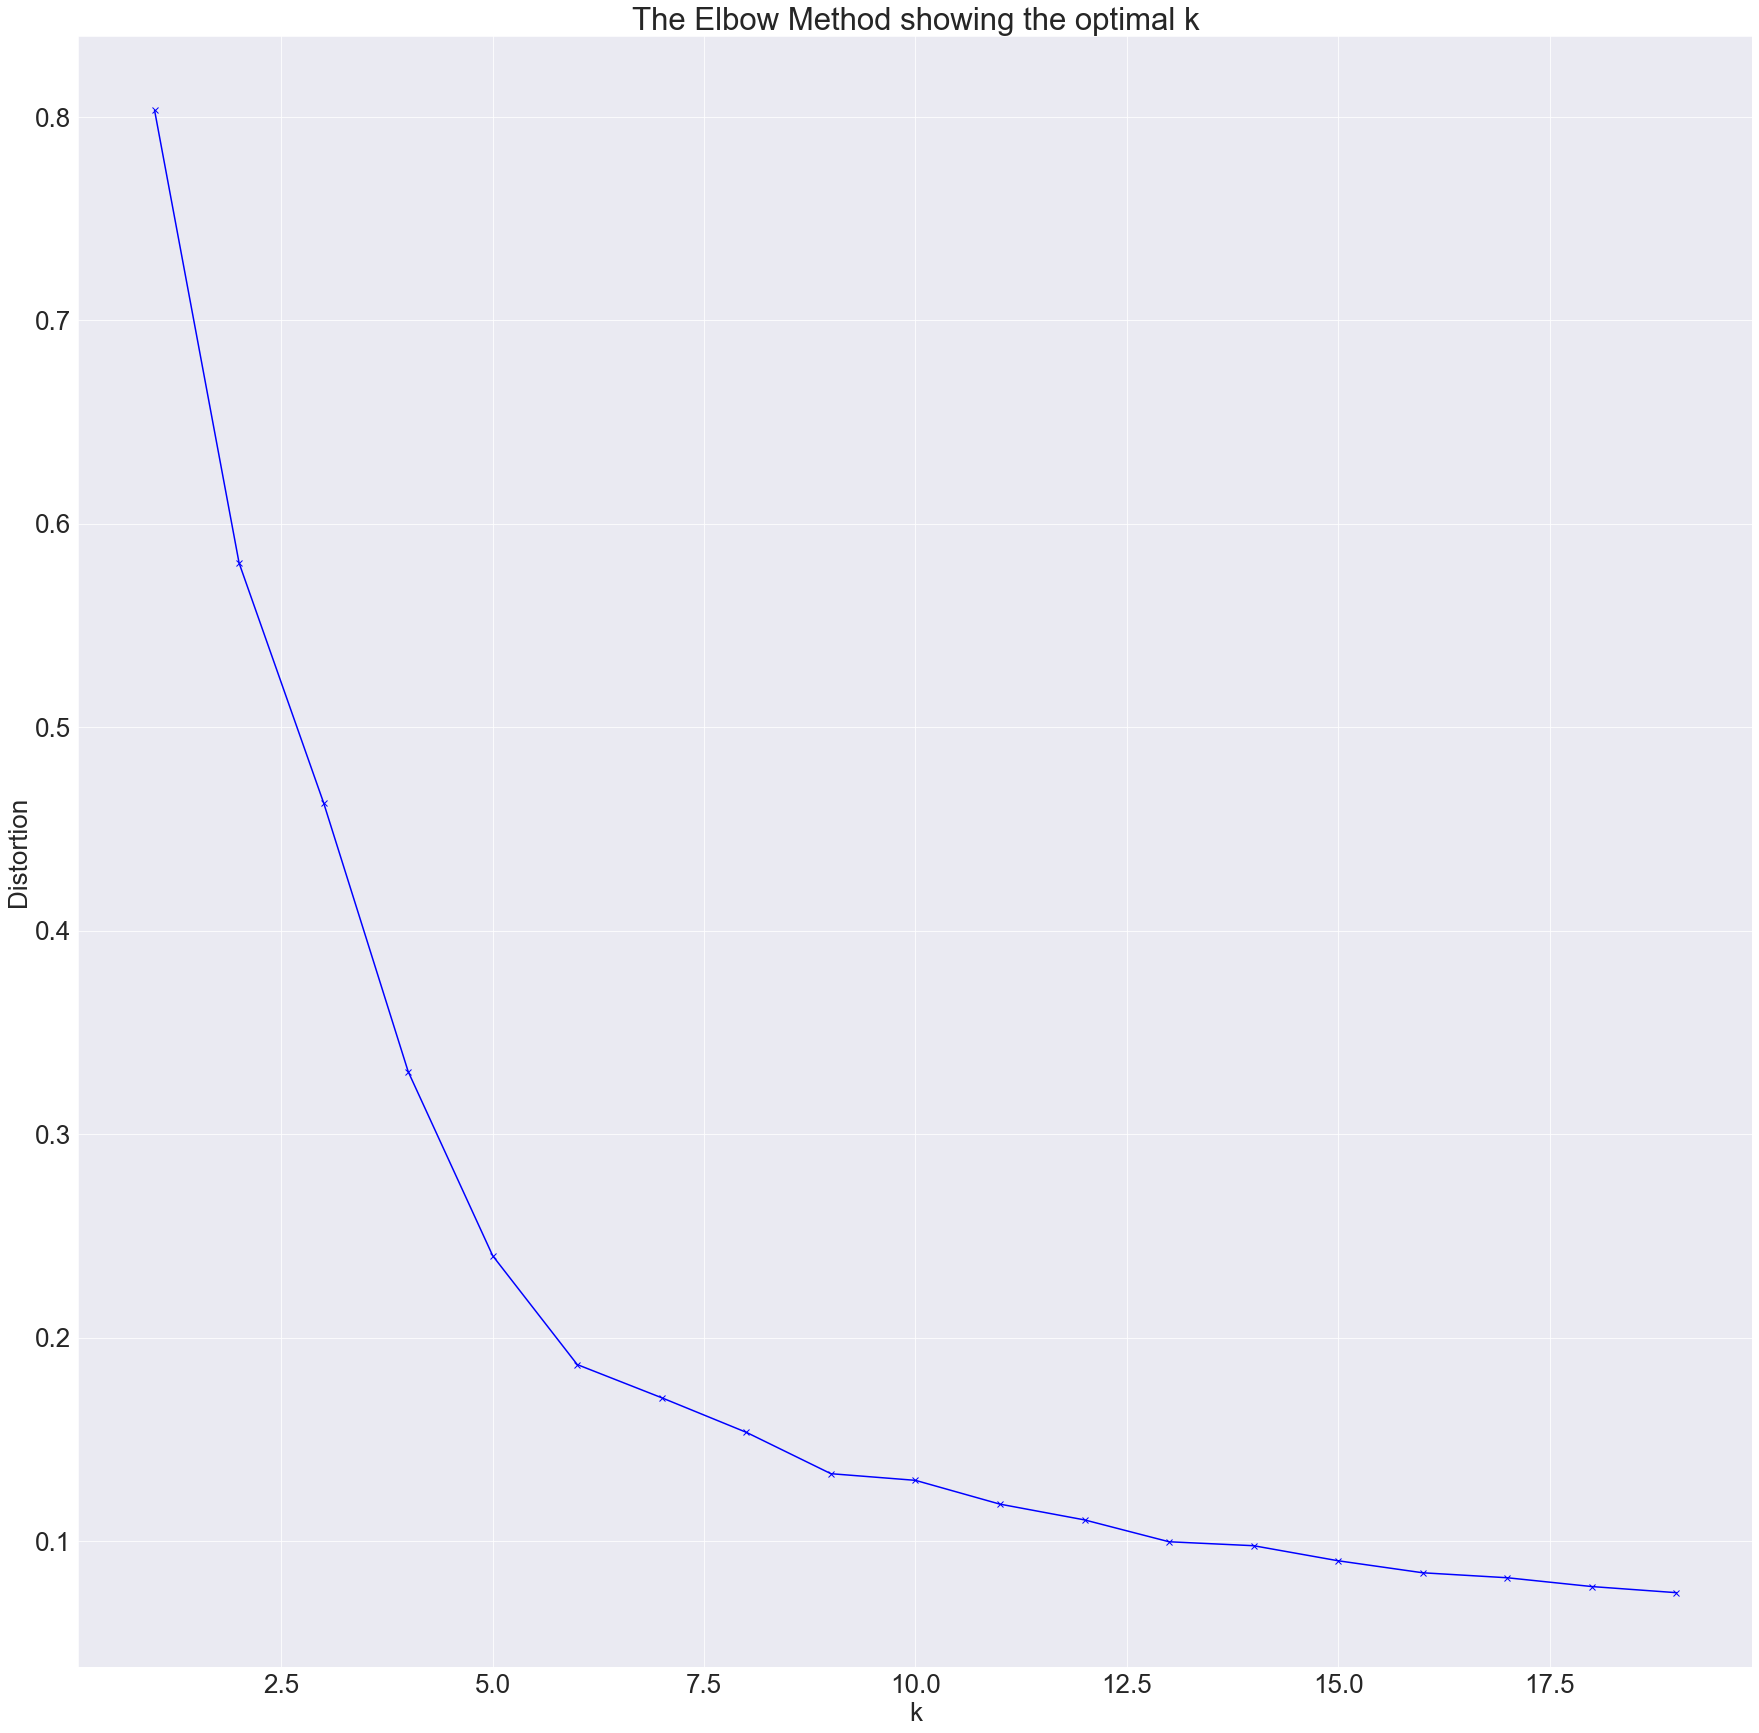

<Figure size 1440x720 with 0 Axes>

In [153]:
elbow_plot(df_test2)

In [147]:
df_test2['group'] = list(hc_test1.fit_predict(df_test2))

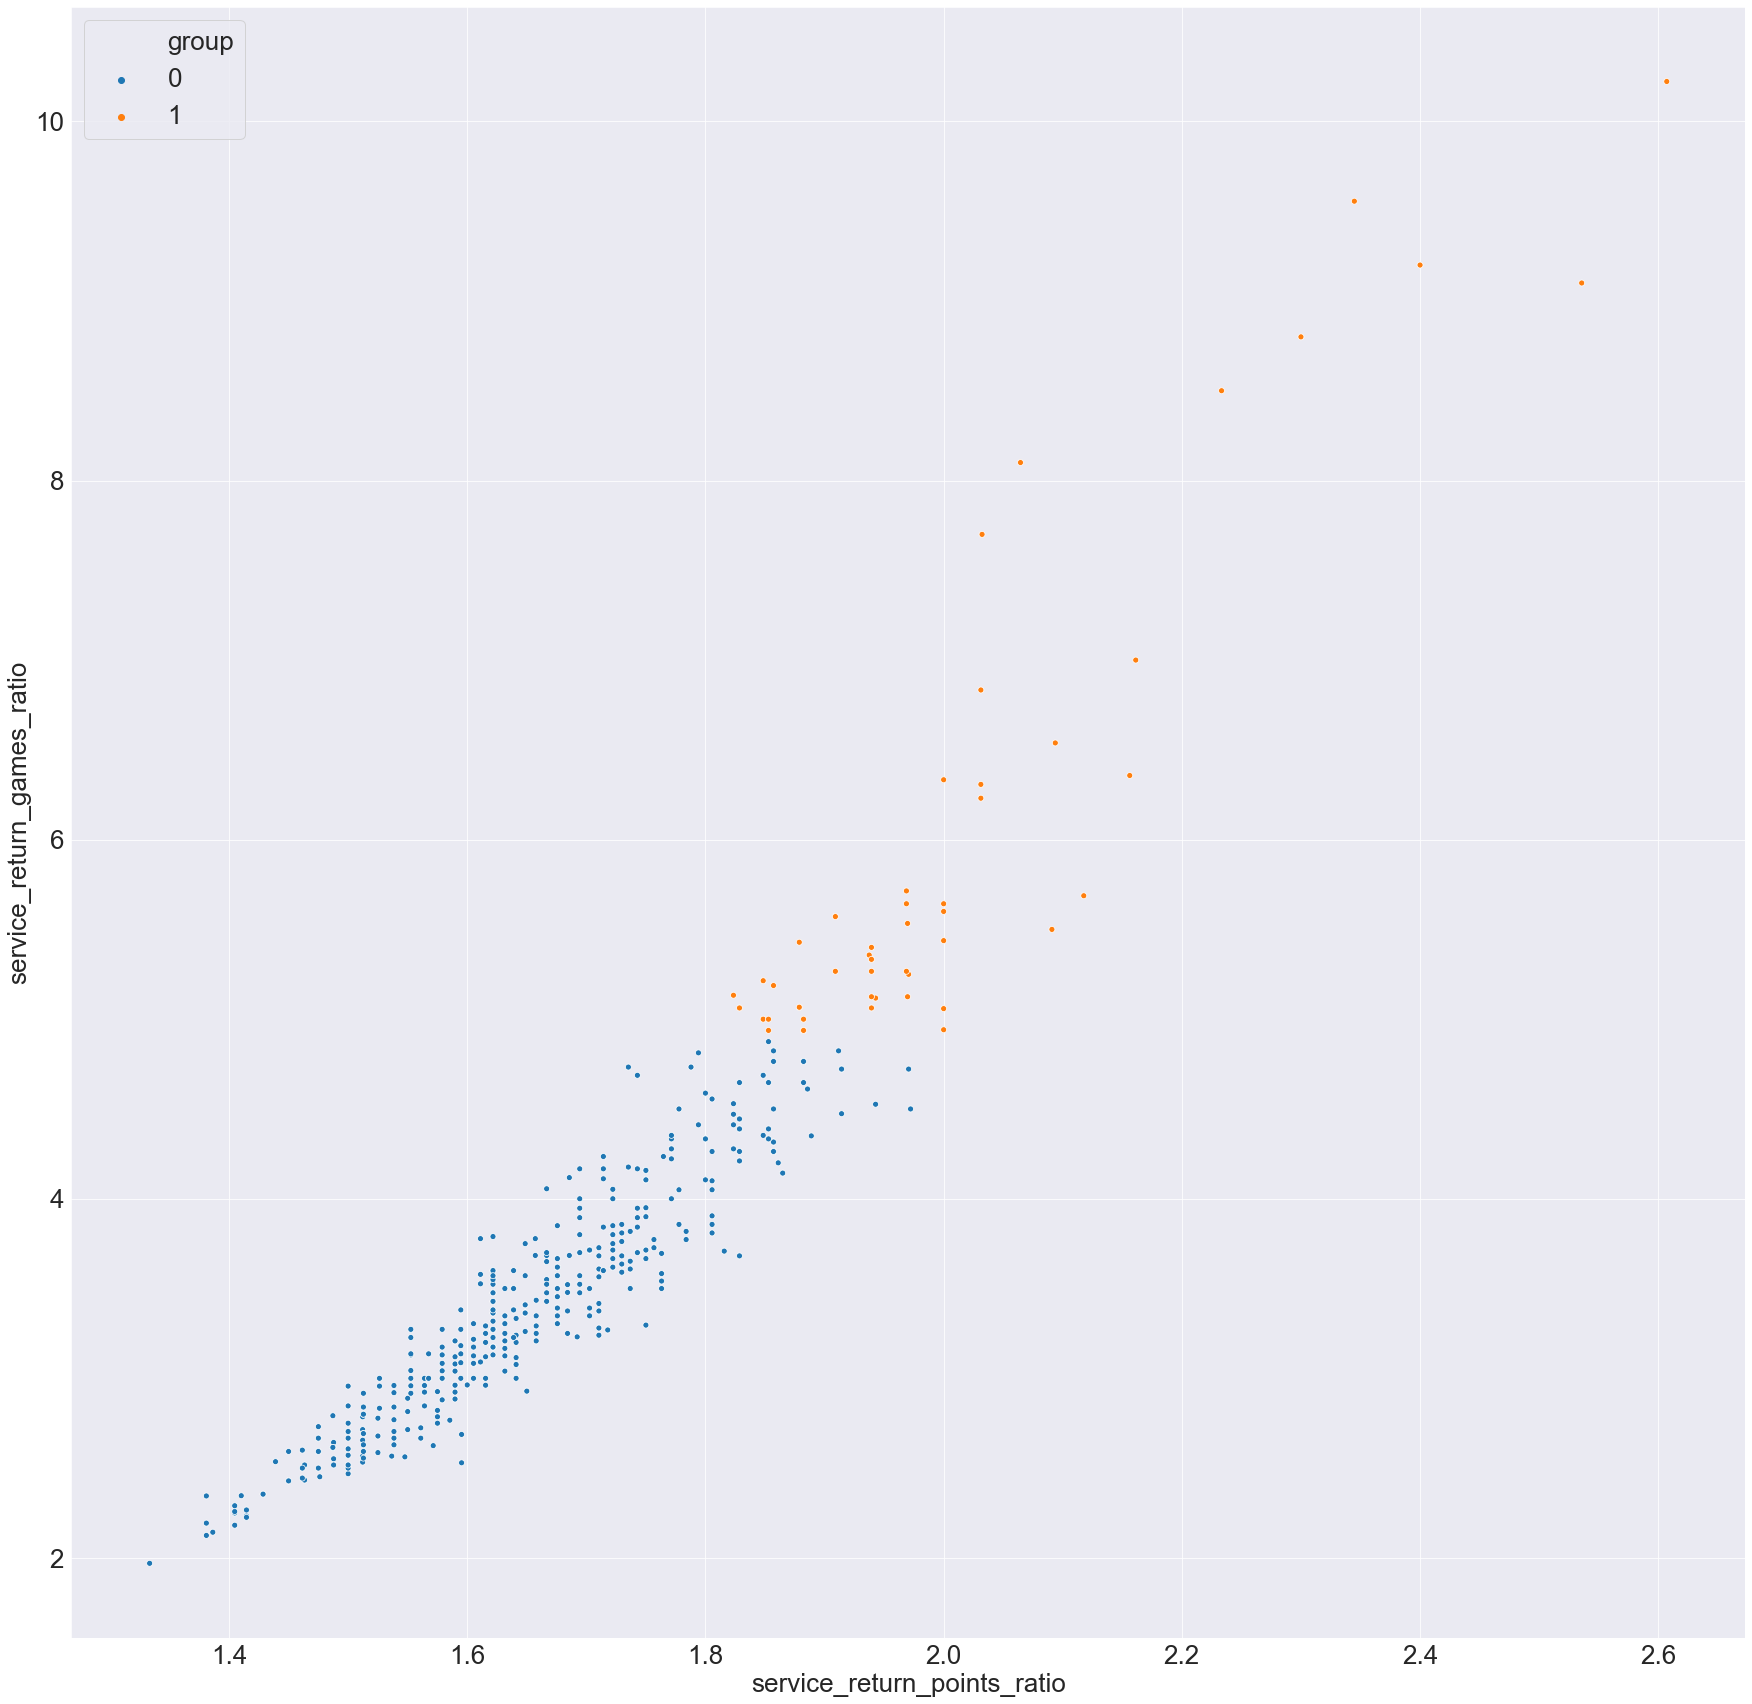

In [149]:
sns.scatterplot(y = df_test2[df_test2.columns[0]], x= df_test2[df_test2.columns[1]], hue = 'group', data = df_test2)

# Principle Component Analysis (PCA)

In [66]:
# Reload & Clean Original CSV

df = pd.read_csv('player_stats_1990-2019.csv')

# Check for missing values
df.isna().sum()

# Convert all percentages into 0.xx
for i in df.columns[4:]:
    df[i] = df[i].map(lambda x: x/100)

## Multicollinearity 

In [67]:
df.drop(['slug', 'player_id'], axis = 1, inplace = True)

In [68]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,height_cm,weight_kg,first_serve_perc,first_serve_points_won_perc,second_serve_points_won_perc,first_serve_return_points_won_perc,second_serve_return_points_won_perc,break_points_saved_perc,break_points_converted_perc,service_games_won_perc,service_points_won_perc,return_games_won_perc,return_points_won_perc
height_cm,1,0.246699,0.0026395,0.30542,0.114567,-0.256481,-0.289909,0.264863,-0.228796,0.302236,0.306619,-0.284635,-0.293181
weight_kg,0.246699,1,-0.0147315,0.470452,0.109591,-0.341177,-0.378059,0.416885,-0.359648,0.456281,0.45745,-0.382922,-0.374194
first_serve_perc,0.0026395,-0.0147315,1,-0.386574,0.15769,0.095719,0.0607791,0.01667,0.0143383,-0.0244171,-0.00184803,0.0781367,0.0557335
first_serve_points_won_perc,0.30542,0.470452,-0.386574,1,0.327865,-0.405206,-0.363319,0.720326,-0.346011,0.876645,0.873002,-0.406316,-0.407132
second_serve_points_won_perc,0.114567,0.109591,0.15769,0.327865,1,-0.0681602,0.0226514,0.550621,-0.00777407,0.648911,0.656156,0.000331591,-0.0403915
first_serve_return_points_won_perc,-0.256481,-0.341177,0.095719,-0.405206,-0.0681602,1,0.752849,-0.310354,0.765809,-0.357253,-0.367817,0.922549,0.929948
second_serve_return_points_won_perc,-0.289909,-0.378059,0.0607791,-0.363319,0.0226514,0.752849,1,-0.255199,0.775494,-0.286044,-0.309523,0.910777,0.913773
break_points_saved_perc,0.264863,0.416885,0.01667,0.720326,0.550621,-0.310354,-0.255199,1,-0.305365,0.857108,0.8265,-0.292818,-0.313839
break_points_converted_perc,-0.228796,-0.359648,0.0143383,-0.346011,-0.00777407,0.765809,0.775494,-0.305365,1,-0.298424,-0.315164,0.860509,0.816219
service_games_won_perc,0.302236,0.456281,-0.0244171,0.876645,0.648911,-0.357253,-0.286044,0.857108,-0.298424,1,0.98196,-0.334712,-0.352896


In [69]:
must_keep = ['height_cm', 'weight_kg','service_games_won_perc', 'return_games_won_perc', 
             'second_serve_points_won_perc', 'second_serve_return_points_won_perc',
            'break_points_saved_perc', 'break_points_converted_perc']
to_drop = ['service_points_won_perc', 'return_points_won_perc',
          'first_serve_points_won_perc', 'first_serve_return_points_won_perc',
          'first_serve_perc']

In [70]:
df.drop(to_drop, axis = 1, inplace = True)

In [71]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,height_cm,weight_kg,second_serve_points_won_perc,second_serve_return_points_won_perc,break_points_saved_perc,break_points_converted_perc,service_games_won_perc,return_games_won_perc
height_cm,1,0.246699,0.114567,-0.289909,0.264863,-0.228796,0.302236,-0.284635
weight_kg,0.246699,1,0.109591,-0.378059,0.416885,-0.359648,0.456281,-0.382922
second_serve_points_won_perc,0.114567,0.109591,1,0.0226514,0.550621,-0.00777407,0.648911,0.000331591
second_serve_return_points_won_perc,-0.289909,-0.378059,0.0226514,1,-0.255199,0.775494,-0.286044,0.910777
break_points_saved_perc,0.264863,0.416885,0.550621,-0.255199,1,-0.305365,0.857108,-0.292818
break_points_converted_perc,-0.228796,-0.359648,-0.00777407,0.775494,-0.305365,1,-0.298424,0.860509
service_games_won_perc,0.302236,0.456281,0.648911,-0.286044,0.857108,-0.298424,1,-0.334712
return_games_won_perc,-0.284635,-0.382922,0.000331591,0.910777,-0.292818,0.860509,-0.334712,1


## Dimension Reduction

In [206]:
pca = PCA(n_components = 1)
transformed = pca.fit_transform(df_test2)

In [207]:
pca.explained_variance_ratio_

array([0.99788451])

In [208]:
pca.explained_variance_ratio_.sum()

0.9978845147799568

In [210]:
pca_df = pd.DataFrame(transformed, columns = ['PC1'])
pca_df.head()

,PC1
0,-0.393836
1,-1.175046
2,-1.018624
3,-1.201977
4,-1.149201


In [211]:
np.cumsum(pca.explained_variance_ratio_)

array([0.99788451])

### K-Means

In [212]:
k_means10 = KMeans(n_clusters=2, random_state = 42)
k_means10.fit(pca_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [213]:
labels10 = k_means10.labels_

print(f"Silhouette Score: {metrics.silhouette_score(pca_df, labels10, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(pca_df, labels10)}")  

Silhouette Score: 0.6179757061068863
Calinski-Harabasz Score: 622.733016536835


In [214]:
k_means10.predict(pca_df)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,

### Hierarchical Agglomerative Clustering

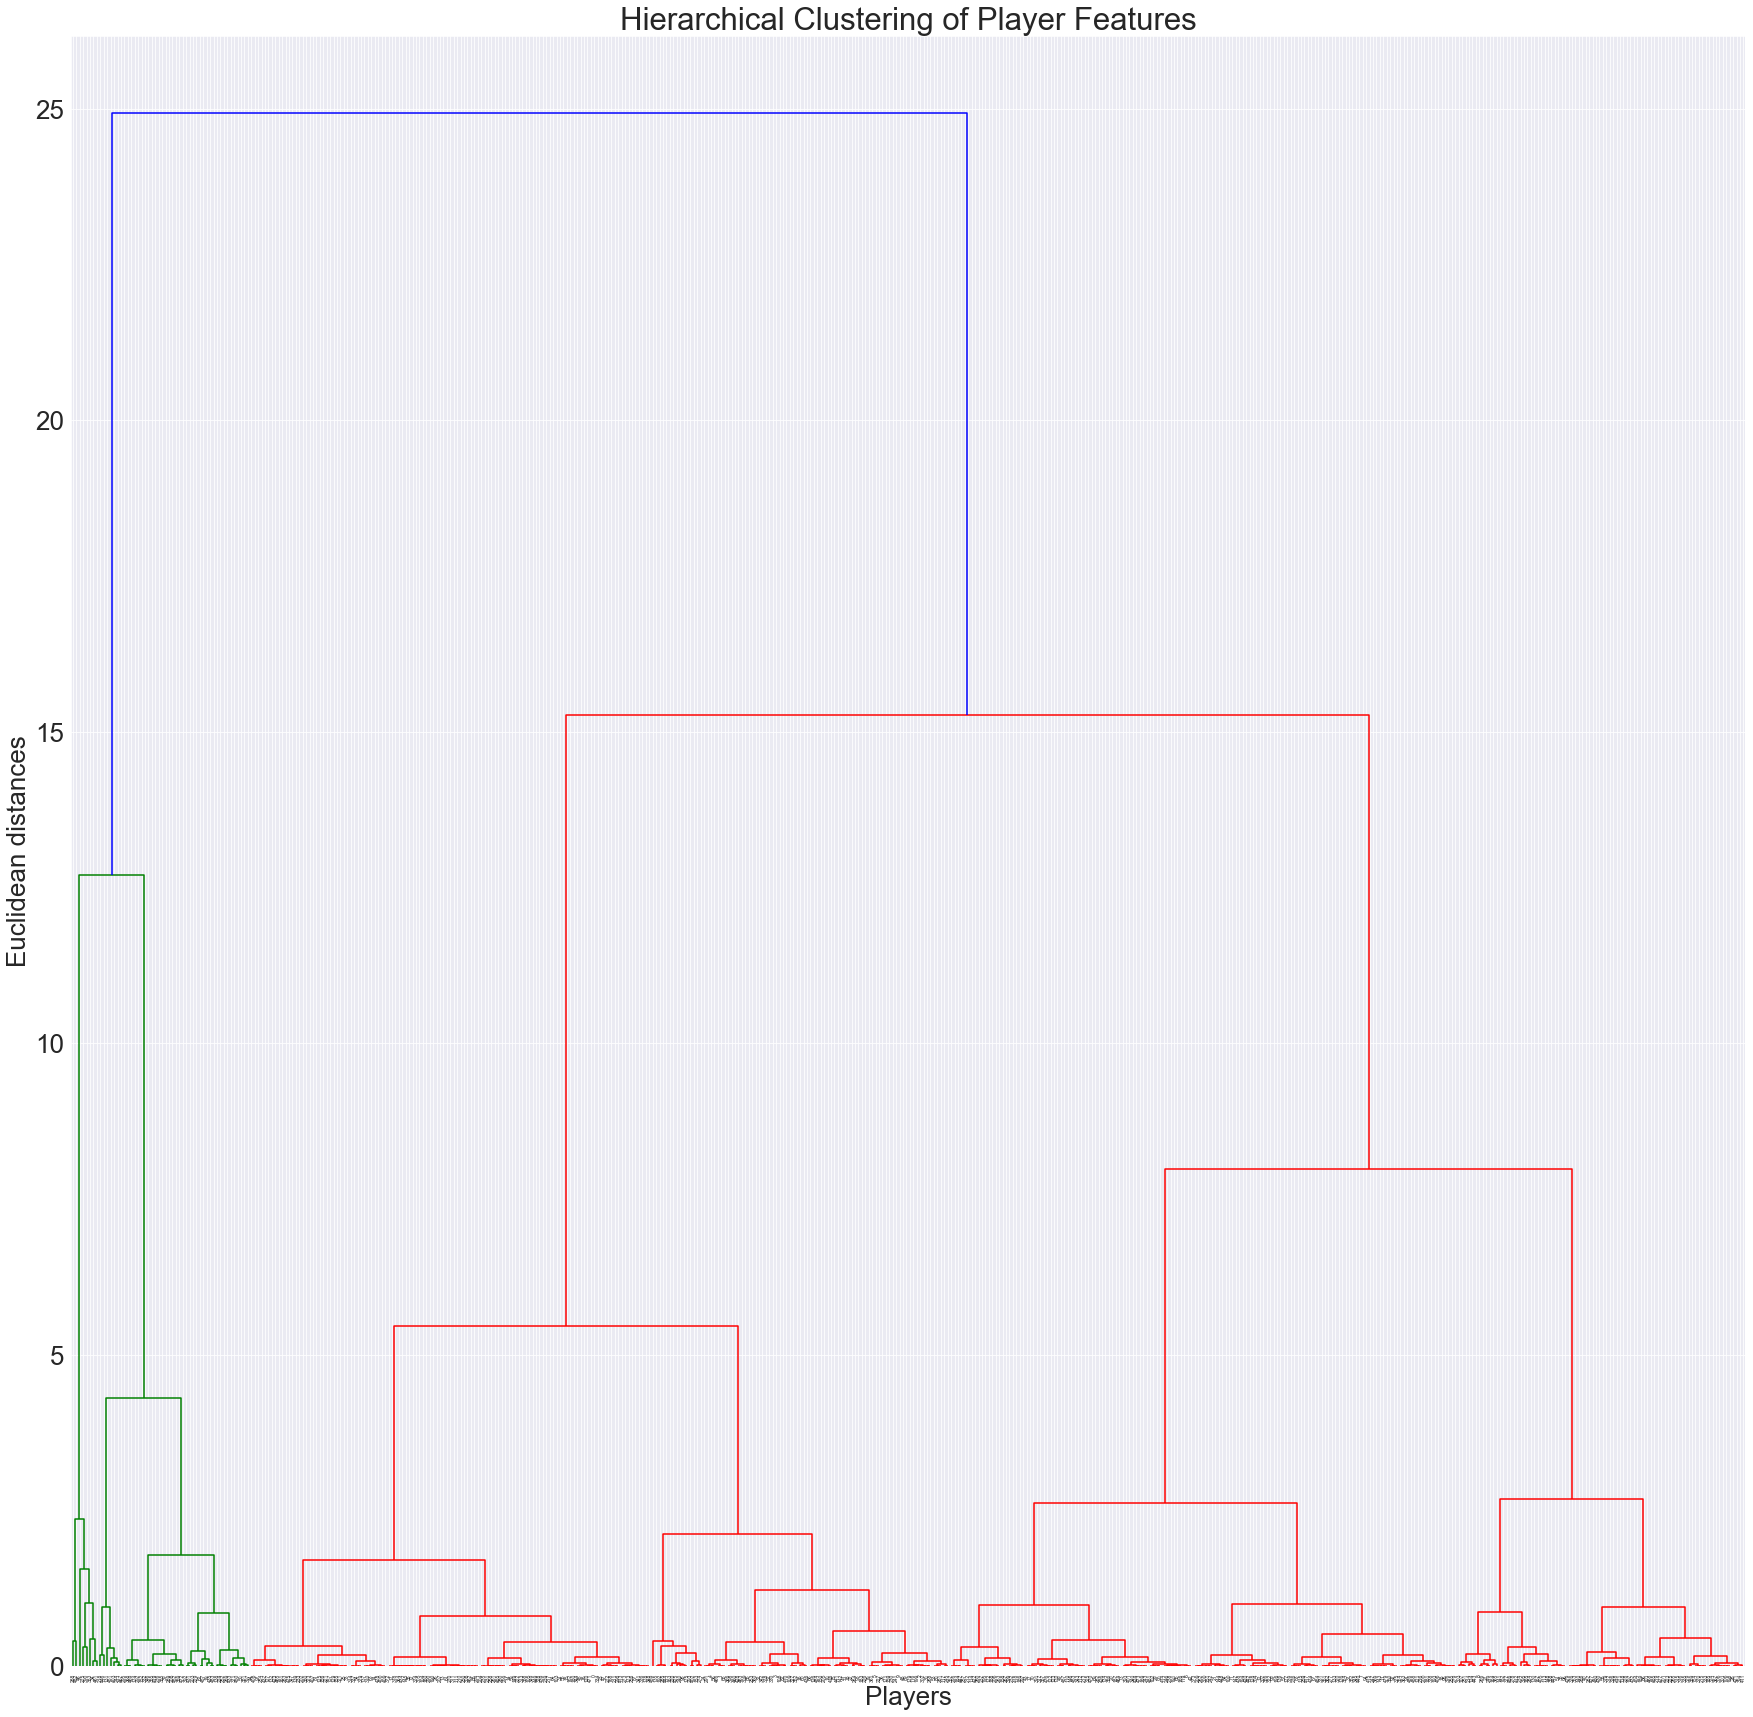

In [215]:
dendrogram = sch.dendrogram(sch.linkage(pca_df, method  = "ward"))
plt.title('Hierarchical Clustering of Player Features')
plt.xlabel('Players')
plt.ylabel('Euclidean distances')
plt.show()

In [216]:
hc_test10 = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
hc_test10.fit(pca_df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2,
                        pooling_func='deprecated')

In [217]:
hc_labels10 = hc_test10.labels_

print(f"Silhouette Score: {metrics.silhouette_score(pca_df, hc_labels10, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(pca_df, hc_labels10)}") 

Silhouette Score: 0.6605816914551785
Calinski-Harabasz Score: 547.5621227109665


In [219]:
pca_df['group'] = hc_test10.fit_predict(pca_df)

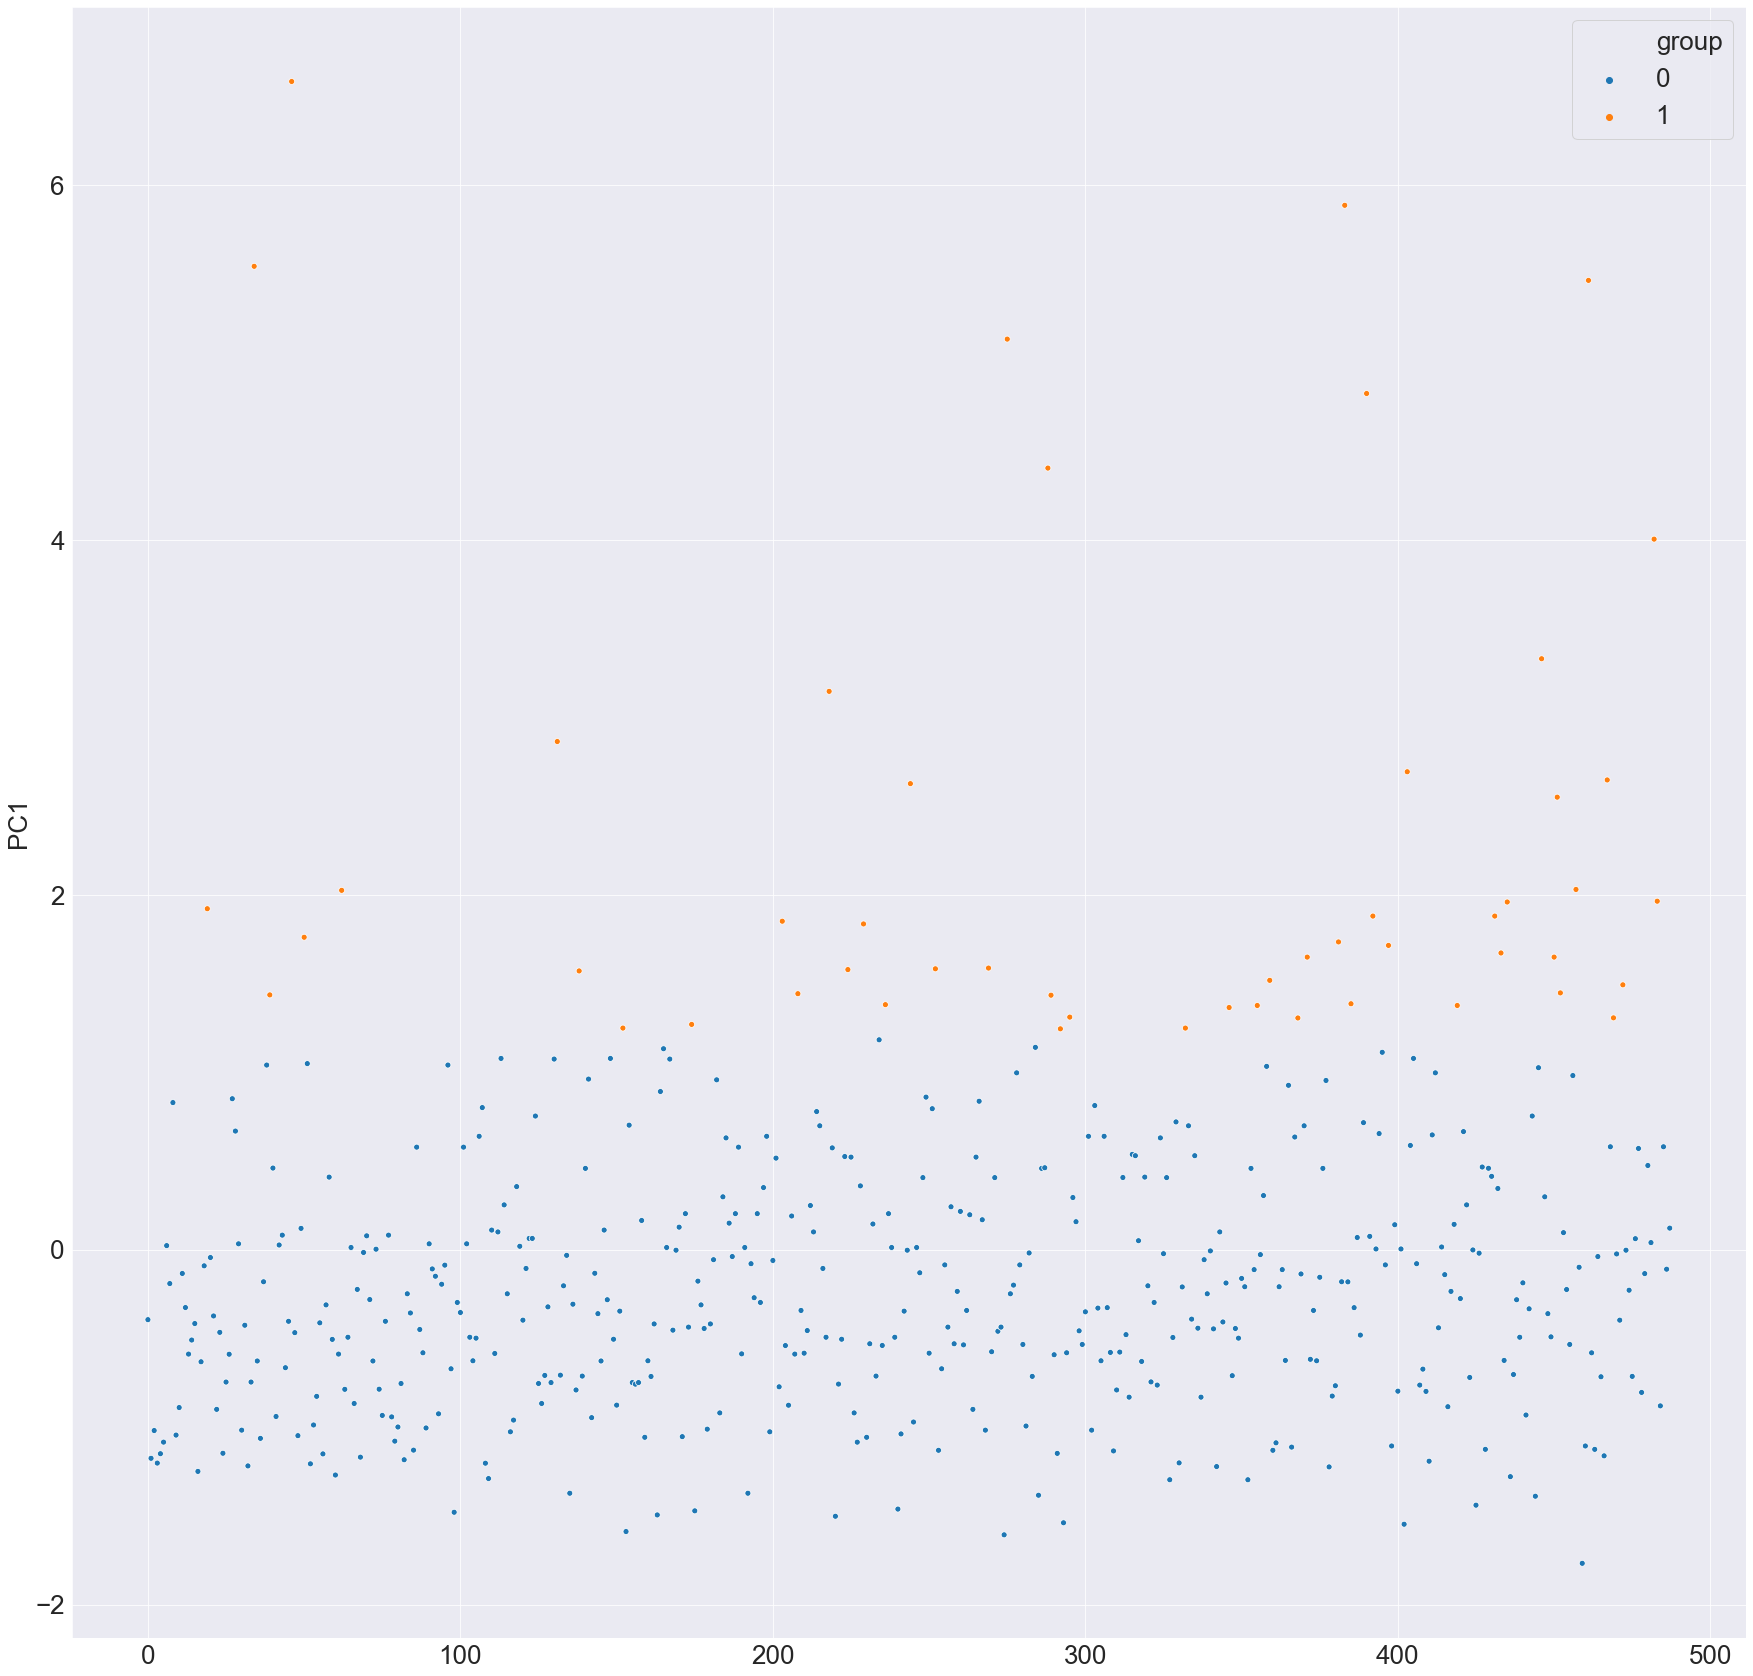

In [221]:
sns.scatterplot(x = pca_df.index, y= pca_df.PC1, hue = 'group', data = pca_df)

# Final Model

In [268]:
# Reload & Clean Original CSV

df = pd.read_csv('player_stats_1990-2019.csv')

# Check for missing values
df.isna().sum()

# Convert all percentages into 0.xx
for i in df.columns[4:]:
    df[i] = df[i].map(lambda x: x/100)
    
# Save player information
df_index = df.drop(df.columns[4:], axis= 1)

In [269]:
df.drop(['slug', 'player_id'], axis = 1, inplace = True)

# Create new columns for ratios
df['service_return_games_ratio'] = np.nan
df['service_return_points_ratio'] = np.nan

# Apply formula to populate both columns
for i in range(0, len(df)):
    df['service_return_games_ratio'][i] = \
    df['service_games_won_perc'][i] / df['return_games_won_perc'][i]
    
    df['service_return_points_ratio'][i] = \
    df['service_points_won_perc'][i] / df['return_points_won_perc'][i]

# Drop other columns
df_test2 = df.drop(df.columns[:-2], axis = 1)

In [270]:
k_means2 = KMeans(n_clusters=2, random_state = 42)
k_means2.fit(df_test2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [271]:
labels2 = k_means2.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test2, labels2, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test2, labels2)}")  

Silhouette Score: 0.6147581532552269
Calinski-Harabasz Score: 619.7806664698721


## Min-Max Scaled

In [274]:
df_test2_1 = df_to_array_scaled(df_test2)

k_means2_1 = KMeans(n_clusters=2)
k_means2_1.fit(df_test2_1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [275]:
labels2_1 = k_means2_1.labels_

print(f"Silhouette Score: {metrics.silhouette_score(df_test2_1, labels2_1, metric='euclidean')}")
print(f"Calinski-Harabasz Score: {metrics.calinski_harabasz_score(df_test2_1, labels2_1)}")

Silhouette Score: 0.8807690730087872
Calinski-Harabasz Score: 6384.831545957696


In [279]:
# Convert array back to dataframe
df_final = pd.DataFrame(df_test2_1, columns = ['service_return_games_ratio', 'service_return_points_ratio'])

In [255]:
# Assigning labels
df_final['group'] = k_means2_1.predict(df_test2_1)

In [280]:
df_final['slug'] = df_index['slug']
df_final['player_id'] = df_index['player_id']
df_final['height_cm'] = df_index['height_cm']
df_final['weight_kg'] = df_index['weight_kg']
df_final = df_final.reindex(['slug', 'player_id','height_cm', 'weight_kg', 'service_return_games_ratio', 'service_return_points_ratio', 'group'], axis = 1)

## Short Summary

Final clustering model segmented players into 2 groups, with players having a more balanced game between service and return in group 0, and players with service-game dominant game in group 1. PCA was tried but proved to be not as useful and less intrepretable, hence we decided to stick to the original metrics but scaled with a MinMaxScaler, with a final silhouette score of 0.88 and a Calinski-Harabasz Score of 5700.

In [281]:
df_final.to_csv('player_with_labels.csv', index = False)